In [54]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats 
from db_utils import get_connection

%matplotlib inline

In [55]:
connection = get_connection()

In [56]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-10-03' and '2022-10-09'
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [57]:
def get_linearized_likes(user_likes, user_views, CTRcontrol):
    linearized_likes = user_likes - user_views * CTRcontrol
    return linearized_likes

In [58]:
CTRcontrol_group_0 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()
CTRcontrol_group_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

# 1 and 2 groups

In [59]:
group1 = df[df.exp_group == 1].copy() #control group
group2 = df[df.exp_group == 2].copy() #treatment group

In [60]:
group1['linearized_likes'] = get_linearized_likes(group1.likes, group1.views, CTRcontrol_group_1)
group2['linearized_likes'] = get_linearized_likes(group2.likes, group2.views, CTRcontrol_group_1)

In [61]:
bins = np.linspace(df.ctr.min(), df.ctr.max(), 100)

In [62]:
groups_1_2 = pd.concat([group1, group2])

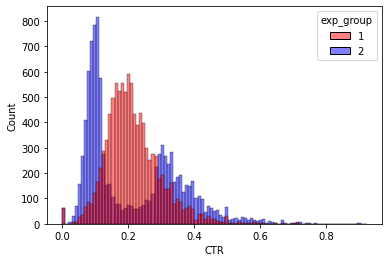

In [63]:
sns.histplot(data = groups_1_2, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              bins = bins,
              kde=False)
_ = plt.xlabel('CTR')

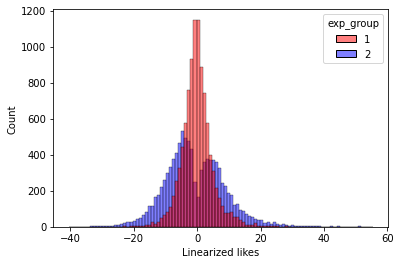

In [64]:
sns.histplot(data = groups_1_2, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              bins = 100,
              kde=False)
_ = plt.xlabel('Linearized likes')

### Проведем тесты для полученных групп:

In [65]:
#Mannwhitney test for linearized likes
stats.mannwhitneyu(group1.linearized_likes, 
                   group2.linearized_likes,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=54534537.0, pvalue=9.404319579641738e-27)

In [66]:
#Mannwhitney test for CTR
stats.mannwhitneyu(group1.ctr, 
                   group2.ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [67]:
#T-test for linearized likes
stats.ttest_ind(group1.linearized_likes, 
                group2.linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)

In [68]:
#T-test for CTR
stats.ttest_ind(group1.ctr, 
                group2.ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

Мы видим, что распределение линеаризированных лайков для второй группы приняло вид, более близкий к нормальному, но оно все также бимодально. T-test показал, что есть статистически значимое различие между группами, в отличие от T-теста, который мы применяли к метрике CTR. Линеаризация также привела к увеличению значения p-value для  теста Манна-Уитни, но оно все еще значительно меньше 0.05, что говорит о статистически значимых различиях между выборками. Но на основании анализа гистограммы, я бы также не рекомендовала раскатывать новый алгоритм на всех новых пользователей, т.к. для части пользователей значение метрики линеаризованных лайков стало явно хуже, нужно дорабатывать модель.

# 0 and 3 groups

In [69]:
group0 = df[df.exp_group == 0].copy() #control group
group3 = df[df.exp_group == 3].copy() #treatment group

In [70]:
group0['linearized_likes'] = get_linearized_likes(group0.likes, group0.views, CTRcontrol_group_0)
group3['linearized_likes'] = get_linearized_likes(group3.likes, group3.views, CTRcontrol_group_0)

In [71]:
groups_0_3 = pd.concat([group0, group3])

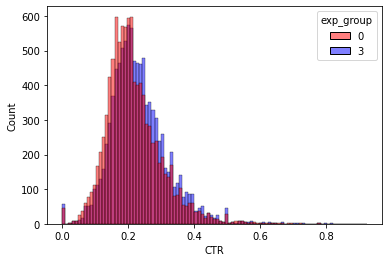

In [72]:
sns.histplot(data = groups_0_3, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              bins = bins,
              kde=False)
_ = plt.xlabel('CTR')

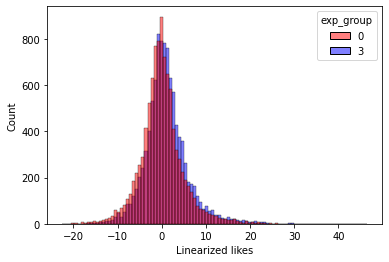

In [73]:
sns.histplot(data = groups_0_3, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              bins = 100,
              kde=False)
_ = plt.xlabel('Linearized likes')

### Проведем тесты для полученных групп:

In [74]:
#Mannwhitney test for linearized likes
stats.mannwhitneyu(group0.linearized_likes, 
                   group3.linearized_likes,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43338326.0, pvalue=1.1517315029786597e-63)

In [75]:
#Mannwhitney test for CTR
stats.mannwhitneyu(group0.ctr, 
                   group3.ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43682792.0, pvalue=1.1952055473582936e-57)

In [76]:
#T-test for linearized likes
stats.ttest_ind(group0.linearized_likes, 
                group3.linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

In [77]:
#T-test for CTR
stats.ttest_ind(group0.ctr, 
                group3.ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

По результатам применения тестов для 0 и 3 группы мы видим, что линеаризация привела к уменьшению p-value как для T-теста, так и для теста Манна-Уитни. Различия между выборками статистически значимы.